In [1]:
#carry out ML to extract urban areas. 
#can then extend this back in time to get when urban change took place.

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

In [3]:
from __future__ import print_function, division
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_squared_error, classification_report
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image as ImageSave
from math import sqrt
import os
from IPython.display import Image

In [4]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [5]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs


In [6]:
###Load in image
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "SENTINEL_2"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (10)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2018-1-1'
baseline_end_date = '2019-12-30'
#nadi
aoi_wkt = "POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))"

#suva
#aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

In [7]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [8]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [9]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3907860.7267941996, 3919261.380868996)
(1855235.5250584628, 1871249.8610571926)


In [10]:
allmeasurements = ["green","red", "blue", "nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_geomedian_annual'
        measurements = allmeasurements
        ###CHANGE WHEN S2 WOFS READY
        #water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements

In [11]:
baseline_product, measurement = create_product_measurement(platform_base)

In [12]:
#create resolution
resolution = (-res, res)

In [13]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [14]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [15]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,
    'measurements': measurement,
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [16]:
baseline_ds = dc.load(
    time = baseline_time_period,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [17]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 2, x: 1602, y: 1141)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02 2019-07-02
  * y        (y) float64 3.919e+06 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x        (x) float64 1.855e+06 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    green    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [18]:
img_ds = baseline_ds.compute()

In [19]:
#NDBI
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)
img_ds['ndbi'] = NDBI(img_ds)

In [20]:
#NDVI
from datacube_utilities.createindices import NDVI
img_ds['ndvi'] = NDVI(img_ds)

In [21]:
#MNDWI
def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)
img_ds['mndwi'] = MNDWI(img_ds)

In [22]:
#BU
img_ds['bu'] = img_ds['ndbi'] - img_ds['ndvi']

In [23]:
#print(img_ds)

In [86]:
T1_img = img_ds.isel(time = 0)

In [112]:
print(len(img_ds.time))

2


In [129]:
for i in range (len(img_ds.time)):
    print(i)
    ab = img_ds.isel(time = i)
    #access datetime as string
    time1 = ab.time.dt.year
    time2= pd.to_datetime(str(time1.values))
    t = time2.strftime('%Y_%m_%d')
    print(t)
    testDic = {'green': 'green_'+ t, 'red': 'red_'+ t, 'blue': 'blue_' + t, 'nir': 'nir_' + t, 'swir1': 'swir1_' + t, 'swir2': 'swir2_' + t, 'ndbi': 'ndbi' + t, 'ndvi': 'ndvi_' + t, 'mndwi': 'mndwi_' + t, 'bu': 'bu_' + t}
    rn = xr.Dataset.rename_vars(ab, testDic)
    rn_D = xr.Dataset.to_array(rn)
    #print(rn_D)
    new_ds = xr.DataArray.drop(rn_D, 'time')
    if i == 0:
        print('n')
        xy = new_ds
    else:
        xy = xy.combine_first(new_ds)
    #print(xy)
    #print('end')
#print(xy)
xds = xr.DataArray.to_dataset(xy, dim = 'variable')
print(xds)

0
2018_01_01
n
1
2019_01_01
<xarray.Dataset>
Dimensions:           (x: 1602, y: 1141)
Coordinates:
  * y                 (y) float64 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x                 (x) float64 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    blue_2018_01_01   (y, x) float64 434.0 435.0 430.0 ... 189.0 202.0 190.0
    blue_2019_01_01   (y, x) float64 521.0 512.0 497.0 ... 223.0 231.0 233.0
    bu_2018_01_01     (y, x) float64 0.04182 0.01844 0.02321 ... -1.383 -1.367
    bu_2019_01_01     (y, x) float64 0.09478 0.08243 0.09474 ... -1.334 -1.311
    green_2018_01_01  (y, x) float64 345.0 344.0 341.0 ... 385.0 423.0 373.0
    green_2019_01_01  (y, x) float64 431.0 420.0 410.0 ... 440.0 436.0 405.0
    mndwi_2018_01_01  (y, x) float64 0.5611 0.5708 0.5714 ... -0.1151 -0.1729
    mndwi_2019_01_01  (y, x) float64 0.3994 0.4094 0.4336 ... -0.1615 -0.194
    ndbi2018_01_01    (y, x) float64 -0.08621 -0.1004 ... -0.4749 -0.4637
    ndbi2019_01_01    (y, x) float

In [87]:
print(T1_img)

<xarray.Dataset>
Dimensions:  (x: 1602, y: 1141)
Coordinates:
    time     datetime64[ns] 2018-07-02
  * y        (y) float64 3.919e+06 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x        (x) float64 1.855e+06 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    green    (y, x) int16 345 344 341 341 340 342 ... 356 379 339 385 423 373
    red      (y, x) int16 163 160 157 161 154 157 ... 171 172 160 169 177 180
    blue     (y, x) int16 434 435 430 433 427 431 ... 173 188 177 189 202 190
    nir      (y, x) int16 126 126 123 121 116 120 ... 3452 2932 3228 3671 3543
    swir1    (y, x) int16 106 103 101 101 92 97 ... 1551 1266 1272 1307 1298
    swir2    (y, x) int16 97 94 93 93 85 88 85 ... 859 649 648 519 518 533 529
    ndbi     (y, x) float64 -0.08621 -0.1004 -0.09821 ... -0.4749 -0.4637
    ndvi     (y, x) float64 -0.128 -0.1189 -0.1214 ... 0.9005 0.908 0.9033
    mndwi    (y, x) float64 0.5611 0.5708 0.5714 ... -0.1473 -0.1151 -0.1729
    bu       (y, x) float64 0.

In [88]:
T2_img = img_ds.isel(time = 1)

2018_01_01


In [108]:
testDic = {'green': 'green_'+ t, 'red': 'red_'+ t, 'blue': 'blue_' + t, 'nir': 'nir_' + t, 'swir1': 'swir1_' + t, 'swir2': 'swir2_' + t, 'ndbi': 'ndbi' + t, 'ndvi': 'ndvi_' + t, 'mndwi': 'mndwi_' + t, 'bu': 'bu_' + t}

In [109]:
testDic2 = {'green': 'green_2019', 'red': 'red_2019', 'blue': 'blue_2019', 'nir': 'nir_2019', 'swir1': 'swir1_2019', 'swir2': 'swir2_2019', 'ndbi': 'ndbi_2019', 'ndvi': 'ndvi_2019', 'mndwi': 'mndwi_2019', 'bu': 'bu_2019'}

In [110]:
T1_rename = xr.Dataset.rename_vars(T1_img, testDic)
T1_renameD = xr.Dataset.to_array(T1_rename)

<xarray.Dataset>
Dimensions:           (x: 1602, y: 1141)
Coordinates:
    time              datetime64[ns] 2018-07-02
  * y                 (y) float64 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x                 (x) float64 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    green_2018_01_01  (y, x) int16 345 344 341 341 340 ... 379 339 385 423 373
    red_2018_01_01    (y, x) int16 163 160 157 161 154 ... 172 160 169 177 180
    blue_2018_01_01   (y, x) int16 434 435 430 433 427 ... 188 177 189 202 190
    nir_2018_01_01    (y, x) int16 126 126 123 121 116 ... 2932 3228 3671 3543
    swir1_2018_01_01  (y, x) int16 106 103 101 101 92 ... 1266 1272 1307 1298
    swir2_2018_01_01  (y, x) int16 97 94 93 93 85 88 ... 649 648 519 518 533 529
    ndbi2018_01_01    (y, x) float64 -0.08621 -0.1004 ... -0.4749 -0.4637
    ndvi_2018_01_01   (y, x) float64 -0.128 -0.1189 -0.1214 ... 0.908 0.9033
    mndwi_2018_01_01  (y, x) float64 0.5611 0.5708 0.5714 ... -0.1151 -0.1729
    b

In [260]:
T1_rename_DD = xr.DataArray.drop(T1_renameD, 'time')

In [37]:
#print(T1_rename_DD)

In [262]:
T2_rename = xr.Dataset.rename_vars(T2_img, testDic2)

In [263]:
T2_renameD = xr.Dataset.to_array(T2_rename)
T2_rename_DD = xr.DataArray.drop(T2_renameD, 'time')

In [264]:
print(T2_rename_DD)

<xarray.DataArray (variable: 10, y: 1141, x: 1602)>
array([[[ 4.31e+02,  4.20e+02,  4.10e+02, ...,  7.40e+02,  7.61e+02,
          7.52e+02],
        [ 4.40e+02,  4.24e+02,  4.16e+02, ...,  7.31e+02,  7.04e+02,
          6.52e+02],
        [ 4.37e+02,  4.24e+02,  4.32e+02, ...,  7.42e+02,  7.16e+02,
          6.87e+02],
        ...,
        [ 4.85e+02,  5.15e+02,  6.48e+02, ...,  3.99e+02,  3.33e+02,
          3.36e+02],
        [ 5.45e+02,  6.41e+02,  6.92e+02, ...,  4.31e+02,  3.77e+02,
          3.95e+02],
        [ 6.40e+02,  7.46e+02,  7.82e+02, ...,  4.40e+02,  4.36e+02,
          4.05e+02]],

       [[ 2.31e+02,  2.23e+02,  2.08e+02, ...,  5.33e+02,  5.69e+02,
          5.94e+02],
        [ 2.46e+02,  2.27e+02,  2.24e+02, ...,  4.51e+02,  4.46e+02,
          4.17e+02],
        [ 2.40e+02,  2.26e+02,  2.36e+02, ...,  4.28e+02,  4.30e+02,
          4.23e+02],
        ...,
        [ 3.95e+02,  3.95e+02,  5.20e+02, ...,  1.80e+02,  1.66e+02,
          1.67e+02],
        [ 3.91e+02, 

In [265]:
#help = xr.merge([T1_rename_DD, T2_rename_DD], dim = 'variable')

In [266]:
help2 = T1_rename_DD.combine_first(T2_rename_DD)

In [34]:
#print(help2)

In [35]:
#stacked = help2.stack(z=("T1", "T2"))

In [36]:
#print(help2)

In [269]:
x = xr.DataArray.to_dataset(help2, dim = 'variable')

In [270]:
print(x)

<xarray.Dataset>
Dimensions:     (x: 1602, y: 1141)
Coordinates:
  * y           (y) float64 3.919e+06 3.919e+06 ... 3.908e+06 3.908e+06
  * x           (x) float64 1.855e+06 1.855e+06 ... 1.871e+06 1.871e+06
Data variables:
    blue_2018   (y, x) float64 434.0 435.0 430.0 433.0 ... 189.0 202.0 190.0
    blue_2019   (y, x) float64 521.0 512.0 497.0 503.0 ... 223.0 231.0 233.0
    bu_2018     (y, x) float64 0.04182 0.01844 0.02321 ... -1.335 -1.383 -1.367
    bu_2019     (y, x) float64 0.09478 0.08243 0.09474 ... -1.326 -1.334 -1.311
    green_2018  (y, x) float64 345.0 344.0 341.0 341.0 ... 385.0 423.0 373.0
    green_2019  (y, x) float64 431.0 420.0 410.0 413.0 ... 440.0 436.0 405.0
    mndwi_2018  (y, x) float64 0.5611 0.5708 0.5714 ... -0.1473 -0.1151 -0.1729
    mndwi_2019  (y, x) float64 0.3994 0.4094 0.4336 ... -0.133 -0.1615 -0.194
    ndbi_2018   (y, x) float64 -0.08621 -0.1004 -0.09821 ... -0.4749 -0.4637
    ndbi_2019   (y, x) float64 0.005155 -0.005376 0.0 ... -0.4327 -0.436

In [27]:
#write_geotiff_from_xr('test_today.tiff', img_ds, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [196]:
#print(T1_img)

<xarray.Dataset>
Dimensions:  (x: 1626, y: 1368)
Coordinates:
    time     datetime64[ns] 2018-07-02
  * y        (y) float64 3.883e+06 3.883e+06 3.883e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    green    (y, x) int16 702 752 685 649 659 633 ... 450 443 438 437 441 443
    red      (y, x) int16 455 494 479 431 439 438 ... 220 217 208 206 209 208
    blue     (y, x) int16 462 490 473 448 483 481 ... 469 463 456 455 455 453
    nir      (y, x) int16 3497 3483 2938 2874 2945 2803 ... 142 136 134 130 130
    swir1    (y, x) int16 1558 1522 1503 1369 1368 1438 ... 129 126 125 125 122
    swir2    (y, x) int16 791 830 819 717 724 769 ... 125 123 117 115 118 116
    ndbi     (y, x) float64 -0.3836 -0.3918 -0.3231 ... -0.01961 -0.03175
    ndvi     (y, x) float64 0.7697 0.7516 0.7196 ... -0.2118 -0.233 -0.2308
    mndwi    (y, x) float64 -0.05961 -0.0493 -0.0891 ... 0.5833 0.5778 0.585
    bu       (y, x) float6

In [194]:
def export_slice_to_geotiff(ds, path, x_coord='longitude', y_coord='latitude'):
    """
    Exports a single slice of an xarray.Dataset as a GeoTIFF.
    ds: xarray.Dataset
        The Dataset to export. Must have exactly 2 dimensions - 'latitude' and 'longitude'.
    x_coord, y_coord: string
        Names of the x and y coordinates in `ds`.
    path: str
        The path to store the exported GeoTIFF.
    """
    kwargs = dict(tif_path=path, data=ds.astype(np.float64), bands=list(ds.data_vars.keys()),
                  x_coord=x_coord, y_coord=y_coord)
    if 'crs' in ds.attrs:
        kwargs['crs'] = str(ds.attrs['crs'])
    write_geotiff_from_xr(**kwargs)

In [271]:
export_slice_to_geotiff(x, 'combine_test_Nadi.tif', x_coord = 'x', y_coord = 'y')

In [ ]:
#####Need to get each band as a seperate netcdf????

In [33]:
#fil1 = 'img_ds_s2_suva_new.tif'

In [39]:
#import rasterio
#with rasterio.open(fil1) as src:
#    for i in src:
#        print(i)

TypeError: 'DatasetReader' object is not iterable

In [200]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [201]:
## vector to raster wtih same res as input raster

In [2]:
from osgeo import gdal
from osgeo import ogr
from osgeo import gdalconst

#dataset from which to base pixel size and extent for rasterization of training datasets
ndsm = 'combine_test_Suva.tif'
#training data
shp = 'attempt106.geojson'
#openlayers
data = gdal.Open(ndsm, gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
#source_layer = data.GetLayer()
#get dimensions
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = ogr.Open(shp)
mb_l = mb_v.GetLayer()
pixel_width = geo_transform[1]
#name for output of rasterized geotif
output = 'my_s2.tif'

target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
proj=data.GetProjection() #y
target_ds.SetProjection(proj)
#target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
geotrans=data.GetGeoTransform()  #get GeoTranform from existed 'data0'

band = target_ds.GetRasterBand(1)
NoData_value = -999999
band.SetNoDataValue(NoData_value)
band.FlushCache()
target_ds.SetGeoTransform(geotrans)
gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=Class"])


target_ds = None

In [203]:
#bands_data = []
#for b in range(1, raster_dataset.RasterCount+1):
 #   band = raster_dataset.GetRasterBand(b)
  #  bands_data.append(band.ReadAsArray())


In [114]:
import rasterio

file_list = ['img_ds_s2_suva_new.tif', '2018_img_ds_s2_Suva_new.tif']

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    #print(src0)
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        #print(layer)
        with rasterio.open(layer) as src2
            img = np.zeros((src1.RasterYSize, src1.RasterXSize, src1.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(src1.GetRasterBand(1).DataType))
           # dst.write_band(id, src1.read(1))
            print(src1)
            for b in range(img.shape[2]):
                print('worked')
            #new = src1.GetRasterBand(b+1).ReadAsArray()
            #print(new)


AttributeError: 'DatasetReader' object has no attribute 'RasterYSize'

In [ ]:
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

##FIGURING OUT HOW TO GET ALL BANDS of ALL TIME PERIODS
###THINK NEED TO MAKE A VRT FROM A LIST OF BANDS??
from osgeo import gdal
outvrt = 'stacked.vrt' #/vsimem is special in-memory virtual "directory"
outtif = 'stacked.tif'
#or for all tifs in a dir
#import glob
#tifs = glob.glob('dir/*.tif')

outds = gdal.BuildVRT(outvrt, file_list, separate=True)
outds = gdal.Translate(outtif, outds)

import rasterio
import numpy as np

#vstack = '/path/to/virtual_stack.vrt'
bands = [1,2,3,4,5,6,7,8,9]

sizeguide = gdal.Open('stacked.tif', gdal.GA_ReadOnly)
print(outvrt)

ulx, xres, xskew, uly, yskew, yres  = sizeguide.GetGeoTransform()
print(ulx)
print(xskew)
lrx = ulx + (sizeguide.RasterXSize * xres)
lry = uly + (sizeguide.RasterYSize * yres)
window = ((xskew, ulx), (yskew, uly))
print(window)M


# define cropping window ((row_start, row_stop), (col_start, col_stop))
#window = ((10, 50), (30, 40))

with rasterio.open(outvrt)as src:
    print(src)
    # Create zero array (you may want to set dtype too)
    #array = np.zeros((window[0][1] - window[0][0],
     #                 window[1][1] - window[1][0],
      #                len(bands)))
    #array = np.zeros((sizeguide.RasterYSize, sizeguide.RasterXSize, len(bands)))
    array = np.zeros((sizeguide.RasterYSize, sizeguide.RasterXSize, sizeguide.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(sizeguide.GetRasterBand(1).DataType))
    # Fill the array
    print(img)
    for b in range(array.shape[2]):
        print(b)
        array[:, :, b] = src.read(b + 1)
    for i, band in enumerate(bands):
        print(i)
        array[:,:,i] = src.read(band)
print(array.shape)

In [71]:
#try seperate
bands_data = []
file1 = 'img_ds_s2_suva_new.tif'
img_ds1 = gdal.Open(file1, gdal.GA_ReadOnly)
img1 = np.zeros((img_ds1.RasterYSize, img_ds1.RasterXSize, img_ds1.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds1.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img1.shape[2]):
    print(b)
    img1[:, :, b] = img_ds1.GetRasterBand(b + 1).ReadAsArray()
    band = img_ds1.GetRasterBand(b + 1)
    bands_data.append(band.ReadAsArray())
#print(bands_data)
#print(img1)

0
1
2
3
4
5
6
7
8
9
[array([[603., 654., 559., ..., 917., 837., 852.],
       [649., 631., 544., ..., 857., 859., 869.],
       [593., 638., 591., ..., 828., 840., 827.],
       ...,
       [196., 196., 204., ..., 460., 469., 469.],
       [186., 189., 208., ..., 461., 464., 452.],
       [185., 190., 213., ..., 454., 453., 451.]]), array([[352., 373., 340., ..., 672., 559., 588.],
       [367., 353., 313., ..., 544., 568., 576.],
       [317., 363., 349., ..., 487., 518., 513.],
       ...,
       [110., 115., 116., ..., 242., 248., 252.],
       [105., 104., 120., ..., 233., 238., 245.],
       [103., 103., 124., ..., 234., 230., 238.]]), array([[417., 444., 412., ..., 597., 506., 532.],
       [438., 399., 363., ..., 518., 517., 518.],
       [382., 407., 394., ..., 483., 474., 479.],
       ...,
       [308., 303., 308., ..., 458., 466., 464.],
       [305., 298., 314., ..., 452., 458., 453.],
       [301., 302., 320., ..., 453., 456., 451.]]), array([[3570., 3515., 2953., ..., 336

In [72]:
print(img1.dtype)

float64


In [4]:
#file2 = '2018_img_ds_s2_Suva_new.tif'
#img_ds2 = gdal.Open(file2, gdal.GA_ReadOnly)
#img2 = np.zeros((img_ds2.RasterYSize, img_ds2.RasterXSize, img_ds2.RasterCount),
 #              gdal_array.GDALTypeCodeToNumericTypeCode(img_ds2.GetRasterBand(1).DataType))
#print(img.dtype)
#for b in range(img2.shape[2]):
#    print(b)
#    img2[:, :, b] = img_ds2.GetRasterBand(b + 1).ReadAsArray()
#    band2 = img_ds2.GetRasterBand(b + 1)
#    bands_data.append(band2.ReadAsArray())
#print(bands_data)

In [86]:
#img_ds = np.asarray(bands_data)

In [5]:
#print(test)

In [6]:
#path to image
#path to training/test data
#roi_ds = gdal.Open('testoutput.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('my_s2.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open('combine_test_Suva.tif', gdal.GA_ReadOnly)

In [7]:
print(img_ds)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f3ca0654a80> >


In [12]:
roi_dataset = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

In [13]:
print(roi_dataset.max())

5


roi = np.zeros((roi_ds.RasterYSize, roi_ds.RasterXSize, roi_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(roi_ds.GetRasterBand(1).DataType))
for b in range(roi.shape[2]):
    roi[:, :, b] = roi_ds.GetRasterBand(b + 1).ReadAsArray()
print(roi)

In [15]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    print(b)
#print(img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
#print(img)

In [95]:
from sklearn_xarray import wrap
from sklearn_xarray.datasets import load_dummy_dataset
from sklearn.preprocessing import StandardScaler

X = load_dummy_dataset()
print(X)
wrapper = wrap(StandardScaler())
print(wrapper)
wrapper = wrapper.fit(X)
#print(wrapper)

#wrapper.estimator_dict_
#{'var_1': StandardScaler(copy=True, with_mean=True, with_std=True)}

ModuleNotFoundError: No module named 'sklearn_xarray'

In [96]:
img = img_ds

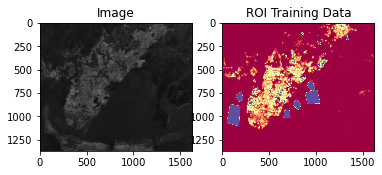

In [17]:
# Display the image and the Training/Test raster
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('Image')
plt.subplot(122)
plt.imshow(roi_dataset, cmap=plt.cm.Spectral, vmin=0, vmax=0.5)
plt.title('ROI Training Data')
plt.show()

In [18]:
labels = np.unique(roi_dataset[roi_dataset > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

The training data include 5 classes: [1 2 3 4 5]


In [19]:
#set X and y as image and training/test data.
#X = img[roi_dataset > 0, :]
X = img[roi_dataset > 0, :]
y = roi_dataset[roi_dataset > 0 ]

In [20]:
#Split the data into training and testing, by 80:20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

In [21]:
unique, counts = np.unique(y_train, return_counts=True)
dict_ytrain = dict(zip(unique, counts))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_ytest = dict(zip(unique2,counts2))
print("counts")
print('Train counts', counts)
print('Test counts', counts2)


counts
Train counts [31559   488   483 31420   583]
Test counts [21040   326   321 20947   389]


In [22]:
X_train2 = np.nan_to_num(X_train)
y_train2 = np.nan_to_num(y_train)

In [23]:
X_test2 = np.nan_to_num(X_test)
y_test2 = np.nan_to_num(y_test)

In [24]:
# Initialize random forest model with 200 trees, and balanced class weight
rf = RandomForestClassifier(n_estimators=200, oob_score=True, class_weight="balanced", min_samples_leaf=100)
rf = rf.fit(X_train2,y_train2)

In [25]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 96.82023150946027%


In [26]:
# Setup a dataframe, for truth and predicted values of training data
df = pd.DataFrame()
df['truth'] = y_train2
df['predict'] = rf.predict(X_train2)
# Setup a dataframe, for truth and predicted values of test data
df2 = pd.DataFrame()
df2['truth'] = y_test2
df2['predict'] = rf.predict(X_test2)

In [27]:
# Cross-tabulate predictions
print(pd.crosstab(df2['truth'], df2['predict'], margins=True))

predict      1    2    3      4     5    All
truth                                       
1        19763   31  616      9   621  21040
2            0  325    1      0     0    326
3            7    3  304      0     7    321
4            0    0    0  20929    18  20947
5            3    5   11      0   370    389
All      19773  364  932  20938  1016  43023


In [28]:
#pip install https://github.com/phausamann/sklearn-xarray/archive/master.zip

In [29]:
#calculate kappa score
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict'])) *100
kappaScore = cohen_kappa_score(df2['truth'], df2['predict'])
kSPer = kappaScore*100
print("this is kappa", kSPer) 
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict']))


this is kappa 94.24373982489774


In [30]:
#calculate accuracy score
print('accuracy score', accuracy_score(df2['truth'], df2['predict']))
#print classification report
print(classification_report(df2['truth'], df2['predict']))

accuracy score 0.969039815912419
              precision    recall  f1-score   support

           1       1.00      0.94      0.97     21040
           2       0.89      1.00      0.94       326
           3       0.33      0.95      0.49       321
           4       1.00      1.00      1.00     20947
           5       0.36      0.95      0.53       389

    accuracy                           0.97     43023
   macro avg       0.72      0.97      0.78     43023
weighted avg       0.99      0.97      0.98     43023



In [31]:
#This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues, annot=True, annot_kws={"size": 3}):
    # Compute confusion matrix
    cm = confusion_matrix(df2['truth'], df2['predict'])
    # Only use the labels that appear in the data
    #classes = ('Built-up', 'Forest', 'Water', 'Grass', 'WB', 'WW', 'OSR')
    classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')
    print("diagonal", cm.diagonal()/cm.sum(axis=1))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    VALUE_SIZE = 10
    LABEL_SIZE = 12

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #show tick labels and label them with list enteries.
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize = LABEL_SIZE)
    plt.setp(ax.get_yticklabels(), fontsize = LABEL_SIZE)
    #path for output of normalised and non-normalised confusion matrices
    notn = 'cm.png'
    norm = 'ncm.png'

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=VALUE_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save the outputs on the confusion matrices
    if normalize:
        plt.savefig(norm)
        print("saved to", norm)
    else:
        plt.savefig(notn)
        print("saved to", notn)
    return ax


diagonal [0.94 1.   0.95 1.   0.95]
Confusion matrix, without normalization
[[19763    31   616     9   621]
 [    0   325     1     0     0]
 [    7     3   304     0     7]
 [    0     0     0 20929    18]
 [    3     5    11     0   370]]
saved to cm.png
diagonal [0.94 1.   0.95 1.   0.95]
Normalized confusion matrix
[[9.39e-01 1.47e-03 2.93e-02 4.28e-04 2.95e-02]
 [0.00e+00 9.97e-01 3.07e-03 0.00e+00 0.00e+00]
 [2.18e-02 9.35e-03 9.47e-01 0.00e+00 2.18e-02]
 [0.00e+00 0.00e+00 0.00e+00 9.99e-01 8.59e-04]
 [7.71e-03 1.29e-02 2.83e-02 0.00e+00 9.51e-01]]
saved to ncm.png


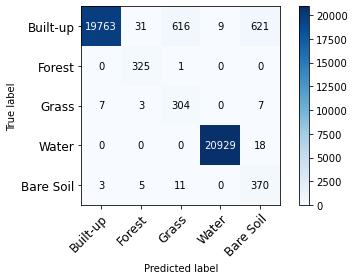

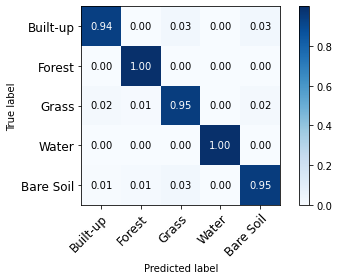

In [32]:
#class labels
classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes)

# Plot normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes, normalize=True)
plt.show()



In [33]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

In [34]:
img_as_array2 = np.nan_to_num(img_as_array)

In [35]:
# Now predict each pixel in the image.
class_prediction = rf.predict(img_as_array2)

In [36]:
# Reshape classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(np.unique(class_prediction))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [37]:
print(class_prediction.shape)
xsize = class_prediction.shape[0]
ysize = class_prediction.shape[1]
print(xsize)

(1368, 1626)
1368


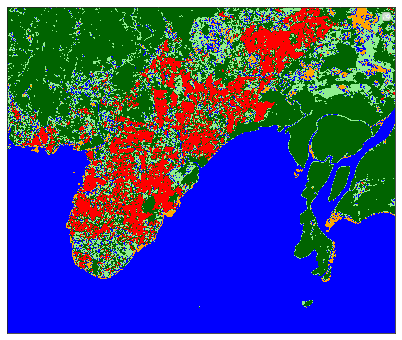

In [38]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction))
plt.show()

In [39]:
dst_filename = 'combined_run.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename, x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction)

# follow code is adding GeoTranform and Projection
geotrans=img_ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Test on new area

In [40]:
#img_ds2 = gdal.Open('img_ds2.tiff', gdal.GA_ReadOnly)
img_ds2 = gdal.Open('combine_test_Nadi.tif', gdal.GA_ReadOnly)

In [41]:
img2 = np.zeros((img_ds2.RasterYSize, img_ds2.RasterXSize, img_ds2.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds2.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img2.shape[2]):
    img2[:, :, b] = img_ds2.GetRasterBand(b + 1).ReadAsArray()
    print(b)
#print(img2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [42]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape3 = (img2.shape[0] * img2.shape[1], img2.shape[2])
img_as_array3 = img2[:, :, :].reshape(new_shape3)

In [43]:
img_as_array4 = np.nan_to_num(img_as_array3)

In [44]:
# Now predict each pixel in the image.
class_prediction2 = rf.predict(img_as_array4)

In [45]:
# Reshape classification map
class_prediction2 = class_prediction2.reshape(img2[:, :, 0].shape)
print(np.unique(class_prediction2))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [46]:
print(class_prediction2.shape)
xsize2 = class_prediction2.shape[0]
ysize2 = class_prediction2.shape[1]
print(xsize2)

(1141, 1602)
1141


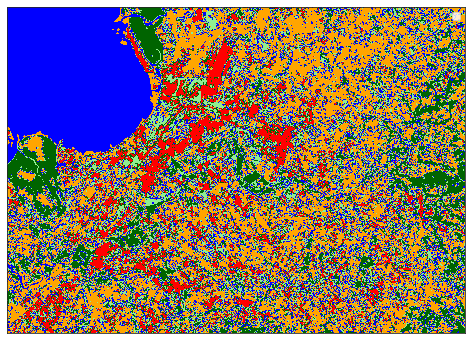

In [47]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction2, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction2))
plt.show()

In [48]:
dst_filename = 'combine_run_nadi.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction2)

# follow code is adding GeoTranform and Projection
geotrans=img_ds2.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds2.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None